In [663]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import shap
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import optuna
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [664]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['metastatic_diagnosis_period'] = -1
new_df = pd.concat([train, test], ignore_index=True)

In [665]:
new_df['breast_cancer_diagnosis_code'] = new_df['breast_cancer_diagnosis_code'].replace({
    'C50122': 'C50112', 'C50221': 'C50211', 'C50421': 'C50411', 'C50922': 'C50912',
    'C509': 'C5091'
})

In [666]:
code_col = 'breast_cancer_diagnosis_code'
desc_col = 'breast_cancer_diagnosis_desc'

In [667]:
new_df['breast_side'] = ''
new_df['breast_site'] = ''
new_df['breast_secondary'] = 0
for index, row in new_df.iterrows(): 
    i = row[desc_col]
    j = row[code_col]
    if 'Secondary' in i:
        new_df.loc[index, 'breast_secondary'] = 1
        new_df.loc[index, 'breast_side'] = 'v_9'
        new_df.loc[index, 'breast_site'] = ''
        continue
    if j.startswith(("17", "19")):
        new_df.loc[index, 'breast_side'] = 'v_9'
    elif 'left' in i:
        new_df.loc[index, 'breast_side'] = 'left'
    elif 'right' in i:
        new_df.loc[index, 'breast_side'] = 'right'
    else:
        new_df.loc[index, 'breast_side'] = 'unspecified'
    if 'upper-outer' in i:
        new_df.loc[index, 'breast_site'] = 'up_out'
    elif 'upper-inner' in i:
        new_df.loc[index, 'breast_site'] = 'up_in'
    elif 'ovrlp' in i :
        new_df.loc[index, 'breast_site'] = 'ovrlp'
    elif 'overlapping' in i:
        new_df.loc[index, 'breast_site'] = 'ovrlp'
    elif 'nipple' in i:
        new_df.loc[index, 'breast_site'] = 'nip_are'
    elif 'central' in i:
        new_df.loc[index, 'breast_site'] = 'center'
    elif 'lower-inner' in i:
        new_df.loc[index, 'breast_site'] = 'low_in'
    elif 'lower-outer' in i:
        new_df.loc[index, 'breast_site'] = 'low_out'
    elif 'central' in i:
        new_df.loc[index, 'breast_site'] = 'center'
    elif 'axillary' in i:
        new_df.loc[index, 'breast_site'] = 'tail'
    else:
        new_df.loc[index, 'breast_site'] = 'unspecified'

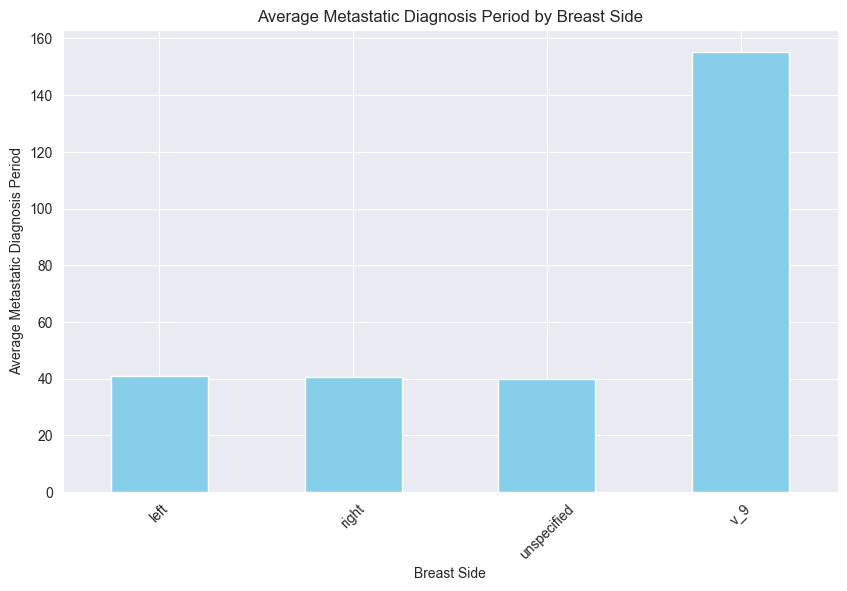

In [668]:
average_period = new_df.groupby('breast_side')['metastatic_diagnosis_period'].mean()

plt.figure(figsize=(10, 6))
average_period.plot(kind='bar', color='skyblue')
plt.title('Average Metastatic Diagnosis Period by Breast Side')
plt.xlabel('Breast Side')
plt.ylabel('Average Metastatic Diagnosis Period')
plt.xticks(rotation=45)
plt.show()

### Why is there such a huge difference between average diagnosis period between ICD10 and ICD9 values?<br>
Possible explanations <br><br>
Coding Standards and Precision:

ICD-10: This version has more detailed and specific codes compared to ICD-9, which might lead to earlier and more accurate diagnoses. As a result, patients diagnosed with ICD-10 codes may be identified earlier in their disease progression, leading to a shorter period until metastasis is diagnosed.
ICD-9: The older ICD-9 codes are less specific, which might lead to diagnoses at a later stage in the disease, resulting in a longer period until metastasis is identified.
<br><br>
Temporal Changes in Medical Practice:

Adoption of ICD-10: The switch to ICD-10 generally occurred around 2015. Medical practices and technologies have advanced significantly since the days when ICD-9 was in use, which could lead to earlier detection and intervention for conditions diagnosed under ICD-10.
ICD-9: Data coded with ICD-9 may represent an older population diagnosed when medical technology and practices were not as advanced, potentially leading to longer metastatic diagnosis periods.


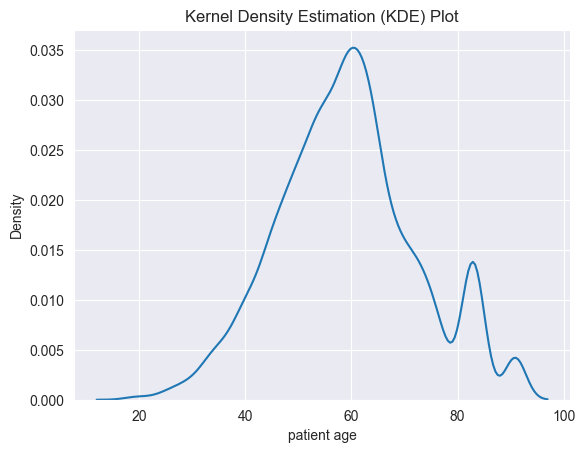

In [669]:
sns.kdeplot(train['patient_age'])
plt.title('Kernel Density Estimation (KDE) Plot')
plt.xlabel('patient age')
plt.ylabel('Density')
plt.show()

### Why is there huge peak at 60 years of age? <br>

Age-related Risk:<br><br>

Menopausal Age: The age around 60 is significant for women as it often coincides with menopause or the period leading up to menopause. Changes in hormone levels during this time can affect the risk of certain types of cancers, including breast cancer which can metastasize to other organs.<br><br>
Hormonal Influences:<br><br>

Estrogen Receptor Positive Breast Cancer: Breast cancers that are estrogen receptor positive (ER+) are more common in postmenopausal women. These cancers can grow in response to estrogen, and hormonal changes during menopause can influence their growth and progression.<br><br>
Cumulative Lifetime Risk:<br><br>

Longer Exposure to Risk Factors: Women in their 60s may have had longer exposure to risk factors for cancer, such as hormonal changes, environmental exposures, lifestyle factors, and genetic predispositions, which can contribute to the development and progression of cancer over time.

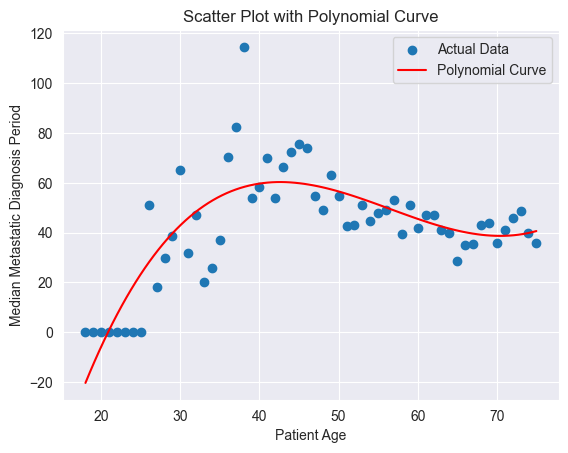

In [670]:
mean_diagnosis_period = train.groupby('patient_age')['metastatic_diagnosis_period'].median()
X = mean_diagnosis_period.index.values[:-9].reshape(-1, 1)  # Remove the last two values
y = mean_diagnosis_period.values[:-9]  # Corresponding y values

# Fit a polynomial regression model
poly_features = PolynomialFeatures(degree=3)  # You can adjust the degree as needed
X_poly = poly_features.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

# Predict for smoother curve
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_pred_poly = poly_features.transform(X_pred)
y_pred = model.predict(X_pred_poly)

# Plot scatter plot
plt.scatter(X, y, label='Actual Data')

# Plot the curve
plt.plot(X_pred, y_pred, color='red', label='Polynomial Curve')

plt.xlabel('Patient Age')
plt.ylabel('Median Metastatic Diagnosis Period')
plt.title('Scatter Plot with Polynomial Curve')
plt.legend()
plt.show()

### Scatter plot of patient age vs average diagnosis period <br>

From this and the previous graph we found out that young women though have very less chance of getting breast cancer they have rapid progression to stage 4(metastatic cancer).

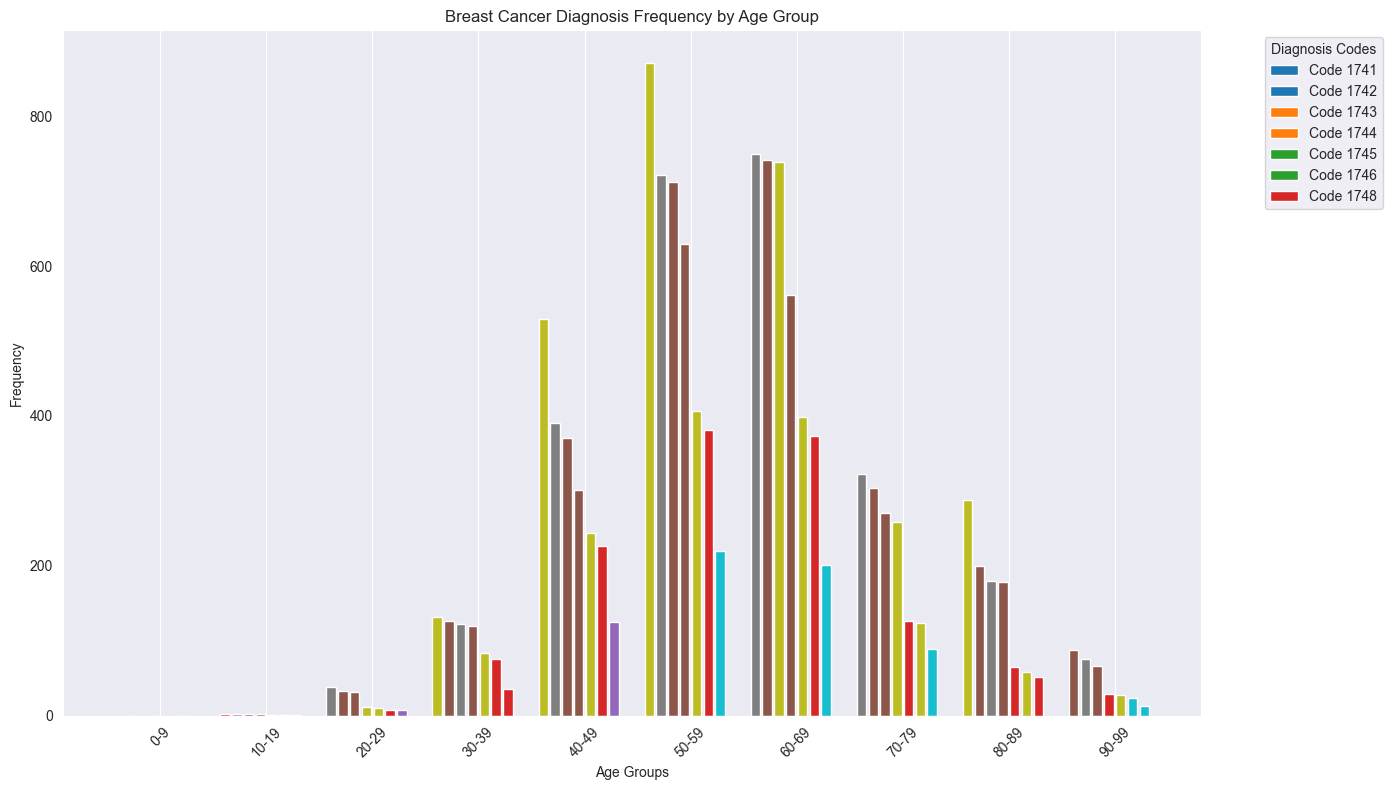

In [671]:
new_df['age_bin'] = pd.cut(new_df['patient_age'], bins=range(0, 101, 10), right=False)

# Group by age bins and metastatic cancer diagnosis code, then count the occurrences
age_diagnosis_counts = new_df.groupby(['age_bin', 'breast_cancer_diagnosis_code']).size().reset_index(name='count')

# Get the top 7 metastatic cancer diagnosis codes for each age bin
top_diagnosis_by_age = age_diagnosis_counts.groupby('age_bin').apply(lambda x: x.nlargest(7, 'count')).reset_index(drop=True)

# Unique age bins
age_bins = top_diagnosis_by_age['age_bin'].unique()

# Unique diagnosis codes within the top 7 for any age bin
unique_diagnosis_codes = top_diagnosis_by_age['breast_cancer_diagnosis_code'].unique()

# Color map for different diagnosis codes
colors = plt.cm.get_cmap('tab10', len(unique_diagnosis_codes))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Store the positions of the bars for labeling
positions_for_labels = []

# Plotting each age bin's data
for i, age_bin in enumerate(age_bins):
    # Filter the data for the current age bin
    data = top_diagnosis_by_age[top_diagnosis_by_age['age_bin'] == age_bin]
    
    # Sort data by counts in descending order
    sorted_data = data.sort_values(by='count', ascending=False)
    sorted_codes = sorted_data['breast_cancer_diagnosis_code']
    sorted_counts = sorted_data['count']
    
    # Calculate the starting position for the current age bin's bars
    start_position = i * (len(sorted_codes) + 2)  # Add extra space between age bins
    
    # Store the central position for labeling purposes
    central_position = start_position + len(sorted_codes) / 2
    positions_for_labels.append((central_position, f"{int(age_bin.left)}-{int(age_bin.right - 1)}"))
    
    # Plot the bars for the current age group
    for j, (code, count) in enumerate(zip(sorted_codes, sorted_counts)):
        ax.bar(start_position + j, count, width=0.8, 
               color=colors(unique_diagnosis_codes.tolist().index(code)), label=f"Code {code}" if i == 0 else "")

# Set x-axis ticks and labels
label_positions, label_texts = zip(*positions_for_labels)
ax.set_xticks(label_positions)
ax.set_xticklabels(label_texts, rotation=45)

# Add labels and title
ax.set_xlabel("Age Groups")
ax.set_ylabel("Frequency")
ax.set_title("Breast Cancer Diagnosis Frequency by Age Group")

# Add grid lines for better readability
ax.grid(axis='y')

# Add a legend to differentiate between diagnosis codes
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Diagnosis Codes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

### Determining most common breast cancer description for each age group <br>
20-30 : Malignant neoplasm of unsp site of right female breast<br>
30-60 : Malignant neoplasm of breast (female), unspecified<br>
60-80 : Malignant neoplasm of unsp site of right female breast
80-90 : Malignant neoplasm of breast (female), unspecified<br>
90-100 : Malignant neoplasm of unspecified site of left female breast<br>


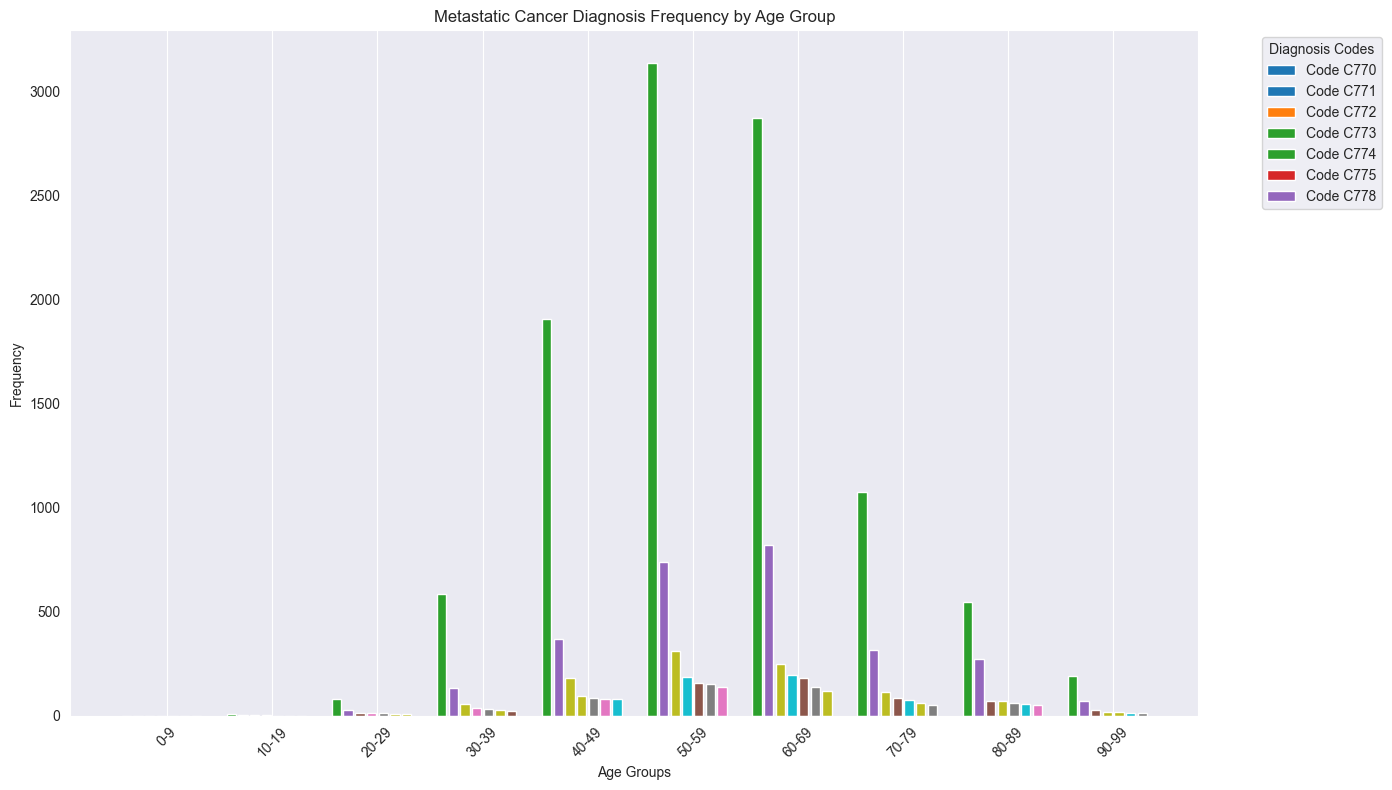

In [672]:

new_df['age_bin'] = pd.cut(new_df['patient_age'], bins=range(0, 101, 10), right=False)

# Group by age bins and metastatic cancer diagnosis code, then count the occurrences
age_diagnosis_counts = new_df.groupby(['age_bin', 'metastatic_cancer_diagnosis_code']).size().reset_index(name='count')

# Get the top 7 metastatic cancer diagnosis codes for each age bin
top_diagnosis_by_age = age_diagnosis_counts.groupby('age_bin').apply(lambda x: x.nlargest(7, 'count')).reset_index(drop=True)

# Unique age bins
age_bins = top_diagnosis_by_age['age_bin'].unique()

# Unique diagnosis codes within the top 7 for any age bin
unique_diagnosis_codes = top_diagnosis_by_age['metastatic_cancer_diagnosis_code'].unique()

# Color map for different diagnosis codes
colors = plt.cm.get_cmap('tab10', len(unique_diagnosis_codes))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Store the positions of the bars for labeling
positions_for_labels = []

# Plotting each age bin's data
for i, age_bin in enumerate(age_bins):
    # Filter the data for the current age bin
    data = top_diagnosis_by_age[top_diagnosis_by_age['age_bin'] == age_bin]
    
    # Sort data by counts in descending order
    sorted_data = data.sort_values(by='count', ascending=False)
    sorted_codes = sorted_data['metastatic_cancer_diagnosis_code']
    sorted_counts = sorted_data['count']
    
    # Calculate the starting position for the current age bin's bars
    start_position = i * (len(sorted_codes) + 2)  # Add extra space between age bins
    
    # Store the central position for labeling purposes
    central_position = start_position + len(sorted_codes) / 2
    positions_for_labels.append((central_position, f"{int(age_bin.left)}-{int(age_bin.right - 1)}"))
    
    # Plot the bars for the current age group
    for j, (code, count) in enumerate(zip(sorted_codes, sorted_counts)):
        ax.bar(start_position + j, count, width=0.8, 
               color=colors(unique_diagnosis_codes.tolist().index(code)), label=f"Code {code}" if i == 0 else "")

# Set x-axis ticks and labels
label_positions, label_texts = zip(*positions_for_labels)
ax.set_xticks(label_positions)
ax.set_xticklabels(label_texts, rotation=45)

# Add labels and title
ax.set_xlabel("Age Groups")
ax.set_ylabel("Frequency")
ax.set_title("Metastatic Cancer Diagnosis Frequency by Age Group")

# Add grid lines for better readability
ax.grid(axis='y')

# Add a legend to differentiate between diagnosis codes
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Diagnosis Codes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

### Finding most common metastatic descriptions for each age group and listing possible reasons

10-100 : c773 : Secondary and unspecified malignant neoplasm of axilla and upper limb lymph nodes

Lymphatic Drainage: The lymphatic system plays a crucial role in breast cancer metastasis. Lymph nodes in the axilla (armpit) and upper limb region are part of the lymphatic drainage network connected to the breasts. Cancer cells can travel through lymphatic vessels and settle in these lymph nodes, leading to metastasis.

Proximity to Breast Tissue: The axilla is close to the breast tissue, making it easier for cancer cells to migrate to nearby lymph nodes. This proximity increases the likelihood of metastasis to axillary lymph nodes.

Biological Factors: Breast cancer cells have certain biological characteristics that make them prone to spreading to lymph nodes and other distant sites. These characteristics include the ability to invade surrounding tissues, survive in the lymphatic system, and establish new tumors (metastases).


### Handling Data inconsistent and filling null values

In [673]:
df = new_df[['patient_zip3', 'patient_state']].copy()
df.drop_duplicates().groupby('patient_zip3', as_index = False)['patient_state'].count().sort_values(by = 'patient_state', ascending = False)

,patient_zip3,patient_state
475,630,2
662,864,2
0,100,1
512,677,1
503,667,1
...,...,...
256,379,1
257,380,1
258,381,1
259,382,1


In [674]:
df.loc[df.patient_zip3.isin([630, 864]), :].sort_values(by = 'patient_zip3')
#630 is MO, 864 is AZ
new_df['patient_state'] = np.where(new_df['patient_zip3'] == 630, 'MO', np.where(new_df['patient_zip3'] == 864, 'AZ', new_df['patient_state']))

In [675]:
new_df[['patient_state', 'Division']].drop_duplicates().groupby([ 'patient_state'], as_index=False)['Division']. \
    count().sort_values('Division', ascending=False).reset_index(drop=True).head()

,patient_state,Division
0,MO,2
1,MT,1
2,NC,1
3,ND,1
4,NE,1


In [676]:
new_df.loc[new_df.patient_state == 'MO', ['patient_state','Division']]

,patient_state,Division
101,MO,West North Central
119,MO,West North Central
186,MO,West North Central
304,MO,West North Central
309,MO,West North Central
...,...,...
18658,MO,West North Central
18751,MO,West North Central
18753,MO,West North Central
18774,MO,West North Central


In [677]:
new_df['Division'] = np.where(new_df['patient_state'] == 'MO', 'West North Central', new_df['Division'])

In [678]:
pop_cols = new_df.loc[:, 'population':'veteran'].columns.to_list()
df_pop = new_df[['patient_zip3', 'patient_state'] + pop_cols].drop_duplicates().sort_values('patient_zip3')

In [679]:
df_pop.groupby('patient_zip3', as_index=False)['population'].nunique().sort_values('population', ascending=False).reset_index(drop=True)

,patient_zip3,population
0,988,2
1,395,2
2,968,2
3,100,1
4,675,1
...,...,...
758,379,1
759,380,1
760,381,1
761,382,1


In [680]:
new_df[new_df.patient_zip3 == 988][['patient_id', 'population']]

,patient_id,population
422,982003,5322.18
749,343406,5322.18
8280,848780,5322.18
8761,724353,5322.18
8765,821607,5322.18
8947,620510,5322.18
9341,367813,5322.18
10245,441322,11511.37
10881,657509,5322.18
12962,155189,5322.18


In [681]:
new_df[new_df.patient_zip3 == 395][['patient_id', 'population']]

,patient_id,population
1670,636245,14629.18
2414,714510,10492.25
3039,365894,14629.18
3311,627529,14629.18
3453,580831,14629.18
6098,531519,14629.18
6551,263784,14629.18
6994,997174,14629.18
8078,694608,14629.18
12359,858866,14629.18


In [682]:
new_df[new_df.patient_zip3 == 968][['patient_id', 'population', 'patient_zip3']]

,patient_id,population,patient_zip3
31,271245,21581.45,968
491,251636,21581.45,968
1797,710844,21581.45,968
1847,271422,13697.21,968
5438,666027,21581.45,968
6574,972239,21581.45,968
8090,474653,21581.45,968
12248,586650,21581.45,968
12518,542344,21581.45,968
13152,454249,21581.45,968


In [683]:
new_df.loc[new_df.patient_id == 714510, pop_cols] = new_df.loc[new_df.patient_id == 636245, pop_cols].values 

new_df.loc[new_df.patient_id == 271422, pop_cols] = new_df.loc[new_df.patient_id == 271245, pop_cols].values 

new_df.loc[new_df.patient_id == 441322, pop_cols] = new_df.loc[new_df.patient_id == 982003, pop_cols].values 

In [684]:
pop_cols = new_df.loc[:, 'population':'veteran'].columns.to_list()
df_pop = new_df[['patient_zip3', 'patient_state'] + pop_cols].drop_duplicates().sort_values('patient_zip3')
df_pop.groupby('patient_zip3', as_index=False)['population'].count().sort_values('population', ascending=False).reset_index(drop=True)

,patient_zip3,population
0,100,1
1,677,1
2,667,1
3,668,1
4,670,1
...,...,...
758,379,1
759,380,1
760,381,1
761,382,1


In [685]:
df_pop[df_pop['family_size'].isnull()]

,patient_zip3,patient_state,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,...,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran
3985,772,TX,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,...,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6


In [686]:
new_df[new_df.patient_zip3 == 772]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,breast_side,breast_site,breast_secondary,age_bin
3985,757384,NaN,COMMERCIAL,TX,772,South,West South Central,43,F,28.0,...,85.06,80.93,71.28,56.46,53.85,40,right,unspecified,0,"[40, 50)"
4404,367375,NaN,COMMERCIAL,TX,772,South,West South Central,61,F,33.1,...,85.06,80.93,71.28,56.46,53.85,36,v_9,low_in,0,"[60, 70)"
6397,749144,NaN,COMMERCIAL,TX,772,South,West South Central,61,F,NaN,...,85.06,80.93,71.28,56.46,53.85,0,left,up_out,0,"[60, 70)"
8028,433905,NaN,COMMERCIAL,TX,772,South,West South Central,62,F,NaN,...,85.06,80.93,71.28,56.46,53.85,36,right,unspecified,0,"[60, 70)"
12209,377675,NaN,COMMERCIAL,TX,772,South,West South Central,71,F,NaN,...,85.06,80.93,71.28,56.46,53.85,47,left,unspecified,0,"[70, 80)"


In [687]:
df_pop[(df_pop['patient_state'] == 'TX') & (~df_pop['limited_english'].isna())].head()

,patient_zip3,patient_state,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,...,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran
113,750,TX,41306.45,1108.94,36.90,13.35,14.67,12.56,14.57,14.90,...,0.05,4.57,8.33,23.30,8.16,7.87,5.72,27.79,13.64,5.92
193,751,TX,16981.35,271.91,38.54,13.25,15.18,11.81,11.80,12.72,...,0.09,4.86,7.59,25.48,14.05,11.85,3.36,34.21,17.66,7.20
217,752,TX,27504.46,1774.32,34.47,12.47,11.93,17.80,16.93,12.70,...,0.03,8.23,8.01,36.19,11.05,17.46,8.92,26.98,20.98,4.76
387,754,TX,5140.34,31.83,42.46,11.46,14.03,10.52,11.22,11.95,...,0.12,2.88,5.07,12.74,17.28,13.18,1.30,29.59,15.86,8.78
594,755,TX,5235.38,48.73,42.13,12.87,13.54,11.09,11.65,12.09,...,0.01,2.08,2.14,8.45,16.09,17.21,0.72,25.28,15.68,8.60


In [688]:
index = df_pop[df_pop['patient_zip3'] == 772].index
cols = df_pop.columns.tolist()
cols.remove('patient_state')
for i in cols:
    if df_pop.loc[index, i].isnull().any():
        mean_value = df_pop[(df_pop['patient_state'] == 'TX') & (~df_pop['limited_english'].isna())][i].mean()
        df_pop.loc[index, i] = mean_value
print(df_pop)

       patient_zip3 patient_state  population   density  age_median  \
69              100            NY    37662.55  29851.69       37.90   
1424            101            NY     2746.14   5363.17       41.25   
1179            103            NY    37938.00   3697.29       39.87   
14              104            NY    58934.16  16936.58       36.22   
1506            105            NY    10690.73    910.85       43.49   
...             ...           ...         ...       ...         ...   
962             992            WA    23864.94   1244.92       35.25   
1343            993            WA    11425.06    136.15       39.65   
5493            994            WA     7442.33     19.20       42.83   
412             995            AK     5629.11    165.46       36.49   
17985           997            AK     1768.39     45.11       34.38   

       age_under_10  age_10_to_19  age_20s  age_30s  age_40s  ...  \
69             8.70          7.81    17.88    20.12    13.02  ...   
1424     

In [689]:
avg_cols = new_df.columns[new_df.columns.str.startswith('Average')].tolist()
df_avg = new_df[['patient_zip3'] + avg_cols].drop_duplicates().sort_values(by='patient_zip3').reset_index(drop=True)

In [690]:
df_avg_melt = pd.melt(df_avg, id_vars=['patient_zip3'])
df_avg_melt['month'] = df_avg_melt['variable'].apply(lambda x: x[len(x)-6:])
df_avg_melt['month'] = pd.to_datetime(df_avg_melt['month'], format='%b-%y')
df_avg_melt.sort_values(by=['patient_zip3', 'month'], inplace=True)
df_avg_melt['value'] = df_avg_melt.groupby(['patient_zip3'])['value'].ffill()
df_avg_melt['value'] = df_avg_melt.groupby(['patient_zip3'])['value'].bfill()
df_avgs = df_avg_melt.drop('month', axis=1).pivot(index=['patient_zip3'],columns='variable', values='value').reset_index()[['patient_zip3'] + avg_cols]
print(df_avgs.shape)
df_avgs

(763, 73)


variable,patient_zip3,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,...,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
0,100,33.44,30.84,38.45,51.26,60.18,71.91,78.55,71.32,64.49,...,37.87,47.55,65.06,70.23,77.12,77.72,69.82,55.79,42.04,37.18
1,101,33.51,30.81,38.44,51.27,60.14,71.98,78.64,71.34,64.53,...,37.95,47.68,65.17,70.33,77.22,77.83,69.93,55.92,42.16,37.26
2,103,34.01,31.87,38.52,51.63,60.29,71.92,78.43,71.46,64.39,...,38.14,47.99,65.17,70.81,76.90,77.75,69.90,56.45,42.55,37.49
3,104,32.81,31.04,38.55,51.15,60.48,71.39,77.86,71.19,64.10,...,37.22,46.54,64.18,69.41,76.37,76.81,68.91,54.75,41.06,36.54
4,105,29.13,27.78,34.54,48.12,58.59,67.86,75.06,68.19,61.44,...,34.47,43.69,62.71,66.81,73.70,73.99,66.41,52.29,38.51,33.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,992,22.85,31.89,39.33,44.39,53.45,58.87,69.29,68.97,60.66,...,37.36,44.85,58.28,59.14,69.22,67.49,56.39,45.00,35.82,30.70
759,993,29.98,39.47,45.29,50.93,60.21,66.23,75.72,74.02,66.51,...,43.72,51.48,64.84,65.76,74.90,72.62,61.87,50.80,40.06,37.40
760,994,27.24,36.06,41.42,45.07,54.96,59.55,68.12,68.49,61.95,...,39.34,46.00,58.69,58.79,67.08,67.50,56.50,47.34,38.45,31.77
761,995,24.28,25.51,26.09,29.90,43.26,56.63,60.11,56.87,48.11,...,28.98,38.66,45.88,53.46,58.54,56.20,51.83,42.66,29.80,24.31


In [691]:
new_df.drop(avg_cols, axis=1, inplace=True)

In [692]:
new_df = pd.merge(new_df, df_avgs, on='patient_zip3', how='left')
new_df.drop(pop_cols, axis=1, inplace=True)
df_pop.drop('patient_state', axis=1, inplace=True)
new_df = pd.merge(new_df, df_pop, on='patient_zip3', how='left')
print(new_df.shape)

(18819, 156)


In [693]:
new_df['Weight_class'] = 'miss'
for index, value in new_df['bmi'].items():
    if pd.isnull(value):
        new_df.loc[index, 'Weight_class'] = 'miss'
    elif value < 18.5:
        new_df.loc[index, 'Weight_class'] = 'underweight'
    elif value < 25:
        new_df.loc[index, 'Weight_class'] = 'healthy'
    elif value < 30:
        new_df.loc[index, 'Weight_class'] = 'overweight'
    else:
        new_df.loc[index, 'Weight_class'] = 'obese'

new_df['bmi_missing'] = np.where(new_df['bmi'].isnull(), 1, 0)
new_df.fillna({'bmi': -1}, inplace=True)
new_df.loc[new_df['bmi'] > 50, 'bmi'] = 23

In [694]:
new_df.drop([code_col, desc_col], axis = 1, inplace = True)

In [695]:
new_df.columns = new_df.columns.str.replace(' ', '_')
new_df.columns = new_df.columns.str.replace('-', '_')

In [696]:
new_df.isnull().sum()

patient_id             0
patient_race        9442
payer_type          2550
patient_state          0
patient_zip3           0
                    ... 
commute_time           0
health_uninsured       0
veteran                0
Weight_class           0
bmi_missing            0
Length: 156, dtype: int64

In [697]:
new_df['payer_type'] = new_df['payer_type'].fillna('COMMERCIAL')

In [698]:
new_df.drop(['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'patient_race', 'age_bin', 'patient_gender'], axis=1, inplace=True)

### Label Encoding Categorical cols for Recursive feature elimination


In [699]:
new_df_rfe = new_df.copy()

In [700]:
col_names = new_df.select_dtypes(include='object').columns.tolist()
for col_name in col_names:
    new_df_rfe[col_name] = new_df_rfe[col_name].astype('category')
    new_df_rfe[col_name] = new_df_rfe[col_name].cat.codes

### One hot Encoding for final model


In [701]:
categorical = new_df.select_dtypes(include='object').columns.tolist()
new_df_te = pd.get_dummies(new_df, columns=categorical)
bool_cols = new_df.select_dtypes(include='bool').columns.tolist()
for i in bool_cols:
    new_df_te[i] = new_df_te[i].astype(int)
new_df_te.drop(['breast_site_'], axis = 1, inplace = True)

In [702]:
new_df_train = new_df_rfe.iloc[:13173].copy()
new_df_test = new_df_rfe.iloc[13173:].copy()
new_df_te_train = new_df_te.iloc[:13173].copy()
new_df_te_test = new_df_te.iloc[13173:].copy()
new_df_test.drop('metastatic_diagnosis_period', axis=1, inplace=True)
new_df_train.drop('patient_id', axis=1, inplace=True)
new_df_te_test.drop('metastatic_diagnosis_period', axis=1, inplace=True)
new_df_te_train.drop('patient_id', axis=1, inplace=True)

### Recursive Feature Elimination using shap

In [703]:
y = new_df_train['metastatic_diagnosis_period']
X = new_df_train.drop(['metastatic_diagnosis_period'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [704]:
model = CatBoostRegressor()

In [705]:
# from catboost import EShapCalcType, EFeaturesSelectionAlgorithm, CatBoostRegressor
# 
# rfe_ctb_full = model.select_features(
#     X                      = X_train, 
#     y                      = y_train, 
#     eval_set               = (X_test, y_test),
#     features_for_select    = X_train.columns.to_list(),
#     num_features_to_select = 10, 
#     algorithm              = EFeaturesSelectionAlgorithm.RecursiveByShapValues,
#     steps                  = 20,
#     verbose                = False,
#     train_final_model      = False, 
#     plot                   = True
# )
# 
# n_to_drop = np.argmin(rfe_ctb_full['loss_graph']['loss_values'])
# cols_to_keep = X.drop(rfe_ctb_full['eliminated_features_names'][:n_to_drop],axis=1).columns.to_list()


In [706]:
# print(cols_to_keep)

In [707]:
pattern = 'payer_type|Region|metastatic_cancer_diagnosis_code|breast_side|breast_site'

# Get all columns after one-hot encoding that match the pattern
all_encoded_cols = new_df_te_train.columns[new_df_te_train.columns.str.contains(pattern)]
# Combine lists properly
train_cols = list(all_encoded_cols) + ['patient_age', 'Average_of_Mar_13', 'Average_of_Nov_13', 'Average_of_Aug_17', 'education_some_college', 'self_employed', 'bmi_missing', 'metastatic_diagnosis_period']
test_cols = list(all_encoded_cols) + ['patient_id', 'patient_age', 'Average_of_Mar_13', 'Average_of_Nov_13', 'Average_of_Aug_17', 'education_some_college', 'self_employed', 'bmi_missing']



In [708]:
new_df_te_train = new_df_te_train.loc[:, train_cols].copy()

new_df_te_test = new_df_te_test.loc[:, test_cols].copy()


In [709]:
y_train = new_df_te_train.loc[:, 'metastatic_diagnosis_period'].copy()
X_train = new_df_te_train.drop(columns='metastatic_diagnosis_period').copy()

### Hyperparameter tuning and Model Selection

In [710]:
def objective1(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 100.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False
    }
    model = CatBoostRegressor(**params)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

    return -scores.mean()


def objective2(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.8, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1),
        'gamma': trial.suggest_float('gamma', 0, 0.2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 4)
    }

    model = XGBRegressor(**params, random_state=42)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    return -scores.mean()

def objective3(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'verbose': -1
    }
    model = LGBMRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)
    return -scores.mean()


def objective4(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    return -scores.mean()


def objective5(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    model = ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

    return -scores.mean()


def objective6(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    max_iter = trial.suggest_int('max_iter', 50, 500)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 20, 100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    l2_regularization = trial.suggest_float('l2_regularization', 0.0, 1.0)

    model = HistGradientBoostingRegressor(
        learning_rate=learning_rate,
        max_iter=max_iter,
        max_leaf_nodes=max_leaf_nodes,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        l2_regularization=l2_regularization,
        random_state=42
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    return -scores.mean()


def objective7(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)  # 
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0)

    model = AdaBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    mean_score = -scores.mean()

    return mean_score


In [711]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective1, n_trials=300)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective2, n_trials=300)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective3, n_trials=300)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective4, n_trials=300)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective5, n_trials=300)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective6, n_trials=300)

In [712]:
cat_boost_params = {'iterations': 1000,
 'learning_rate': 0.010037322730322665,
 'depth': 7,
 'l2_leaf_reg': 2.387386725390864,
 'random_strength': 0.1866145466052265,
 'bagging_temperature': 47.55153797256439,
 'border_count': 68,
 'verbose': 0}
xgb_params = {'n_estimators': 241,
 'max_depth': 3,
 'learning_rate': 0.05148804469290124,
 'subsample': 0.896584781095636,
 'colsample_bytree': 0.8255808538604268,
 'gamma': 0.17391792925230765,
 'min_child_weight': 2}
lgb_params = {'n_estimators': 597,
 'learning_rate': 0.024794157529878638,
 'num_leaves': 155,
 'max_depth': 3,
 'min_child_samples': 31,
 'min_child_weight': 0.01917971322917641,
 'subsample': 0.5856439151553617,
 'colsample_bytree': 0.5609507052199069,
 'reg_alpha': 0.025349393072598217,
 'reg_lambda': 0.0012371298809846604,
 'verbose' : -1}
random_forest_params =  {'n_estimators': 97, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_features': 0.965923867853466}
extra_trees_params =  {'n_estimators': 185, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 0.3913533140997396}
hist_gradient_boosting_params = {'learning_rate': 0.0662643931631377,
 'max_iter': 115,
 'max_leaf_nodes': 21,
 'max_depth': 9,
 'min_samples_leaf': 20,
 'l2_regularization': 0.6796408988909955}

catboost_model = CatBoostRegressor(**cat_boost_params)
xgb_model = XGBRegressor(**xgb_params)
lgb_model = LGBMRegressor(**lgb_params)
random_forest_model = RandomForestRegressor(**random_forest_params)
extra_trees_model = ExtraTreesRegressor(**extra_trees_params)
hist_gradient_boosting_model = HistGradientBoostingRegressor(**hist_gradient_boosting_params)


### Ensembling using custom stack regressor

In [713]:
model_list =\
    {'catboost' : catboost_model,
    'xgboost' : xgb_model,
    'lightgbm' : lgb_model,
    'random_forest' : random_forest_model,
    'extra_trees' : extra_trees_model,
    'hist_gradient_boosting' : hist_gradient_boosting_model
     }
for model_name, model in model_list.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print(f"{model_name} trained successfully.")
ensemble_df = pd.DataFrame(y_train)
for model_name, model in model_list.items():
    ensemble_df[model_name] = model.predict(X_train)

Training catboost...
catboost trained successfully.
Training xgboost...
xgboost trained successfully.
Training lightgbm...
lightgbm trained successfully.
Training random_forest...
random_forest trained successfully.
Training extra_trees...
extra_trees trained successfully.
Training hist_gradient_boosting...
hist_gradient_boosting trained successfully.


In [714]:
X_test = new_df_te_test.drop('patient_id', axis=1)
ensemble_df_test = pd.DataFrame()
for model_name, model in model_list.items():
    ensemble_df_test[model_name] = model.predict(X_test)

In [715]:
y_train_e = ensemble_df['metastatic_diagnosis_period'].copy()
X_train_e = ensemble_df.drop(['metastatic_diagnosis_period'], axis=1).copy()

In [716]:
cat_meta = CatBoostRegressor(**cat_boost_params)
cat_meta.fit(X_train_e, y_train_e)

### Prediction

In [717]:
sub = pd.DataFrame()
sub['patient_id'] = new_df_te_test['patient_id'].copy()
sub['metastatic_diagnosis_period'] = cat_meta.predict(ensemble_df_test)
sub.to_csv('last_sub.csv', index=False)
sub

,patient_id,metastatic_diagnosis_period
13173,730681,174.981533
13174,334212,80.897415
13175,571362,184.540536
13176,907331,202.874910
13177,208382,41.167681
...,...,...
18814,649011,37.381925
18815,869024,91.778896
18816,304800,234.570273
18817,267406,52.337591
